Today, i want to discuss about Batch Normalization and how it is speeds up learning

### Current problems

One of the biggest problem that we have in deep neural networks is Internal covariance shift - the change in the distribution of network activations due to the change in network parameters during training. As in paper said: "Eliminating it offers a promise of faster training".

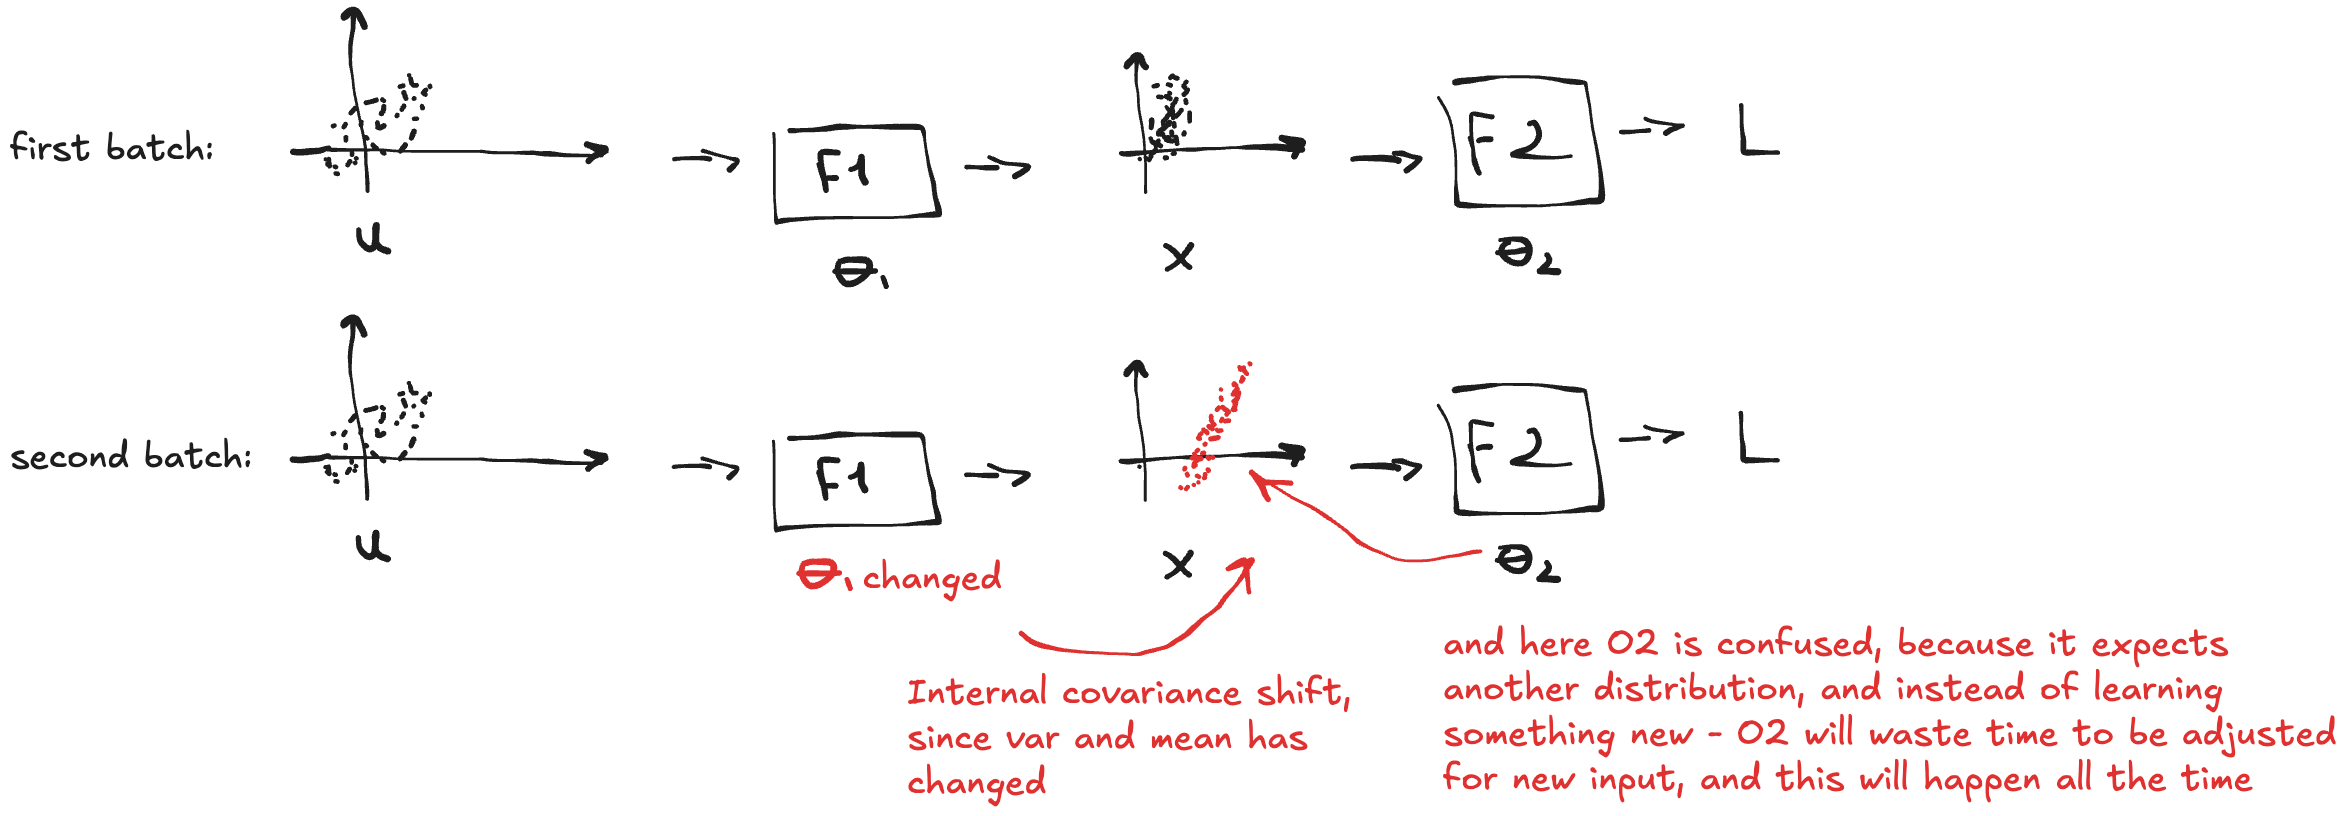

Okay, but why having different output distributions across layers is such a bad idea? There are few reasons:
1. **Moving target problem**. In the picture above we see this problem. Every time when we take optimization step in order to decrease loss, we change params, and we change this params based on distribution that they get from the previous layer: model tries to adjust these params to the distribution in order to make prediction correctly. But, when model gets another batch samples, layers can produce another distribution, and this can cause misunderstanding, "moving target", since know model again have to adjust params to new distribution, not learn something  deeply.
2. **The Saturation and Vanishing Gradient Trap**. When distributions differ wildly across layers, activations often drift into the "danger zones" of non-linear functions like Sigmoid or Tanh. If a distribution shifts too far in a positive or negative direction, the inputs to the next layer become very large. On the flat ends of a Sigmoid curve, the gradient is nearly zero. If the distribution stays in this area, the weights stop updating because the "signal" to change them disappears.
3. **Requirements for small learning rate**. Without stable distributions, you are forced to use very small learning rates. If you use a large learning rate, a single update might shift the distribution of Layer 1 so much that Layer 2 becomes completely "confused" or saturated. Small learning rates prevent this "explosion," but they make the model take a very long time to converge. 
4. **Sensitivity to initialization**. In layers with different or unstable distributions, the initial values of your weights become high-stakes. If the initial weights are slightly off, they can cause the distributions in deeper layers to be so skewed that the model never starts learning.

### Batch Normalization 

To solve all of the problems above, reseachers came up with some interesting idea - Batch Normalization layer. In simple words, after some transformations, before acivations, we add normalization layer, that scales and shifts distribution to have mean at 0 and variance = 1. This approach provides:
1. Accelerating the training of deep neural nets.
2. Use of much higher learning rate.
3. Regularization, such that reduce the need of Dropout

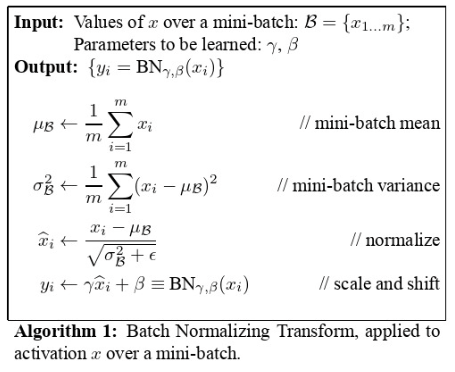

Above there is an algorithm of Batch Normalization. The key moment - that we apply it for every batch, meaning that statistics such as variance or mean dependns on specific batch. Also, important to mention that except of normalization, we also use additional learning params in order to be able to return to original disitrbution.

As it turns out, quite serendipitously, batch normalization conveys all three benefits: preprocessing, numerical stability, and regularization.

### Experiments

In [1]:
import sys
import os

sys.path.append(os.path.abspath("../..")) 

from utils.utils import min_max_scaling, \
    set_random_seeds, plot_images, get_top_k_confident_mistakes, compute_FLOPS, compare_architectures, \
    plot_top_mistakes, plot_training_results, plot_filters_and_feature_maps, count_params, get_gpu
from models.AlexNet import AlexNet
from models.LeNet import LeNetBaseline, LeNetBNDropout, LeNet, LeNetDropout, LeNetFullBN, LeNetMeanOnly, LeNetVarOnly, LeNetFixedBN
from models.VGG import VGG, get_vgg_features
from models.NiN import NiN, NiN_without_AGP
from engine.DatasetProvider import DatasetProvider, DatasetName
from engine.Trainer import Trainer
from models.AlexNet import AlexNet
from models.GoogLeNet import GoogLeNet
import torchvision
from torchvision.transforms import transforms
import torch.nn.functional as F
import torch
from torch import nn
import torch.utils.data as data
from torchinfo import summary
import copy
import numpy as np
import matplotlib.pyplot as plt

In [2]:
OUT_FEATURES = 10 

models_to_compare = [
    {"name": "Baseline_(No_BN)", "model": LeNetBaseline(OUT_FEATURES)},
    {"name": "Full_BatchNorm",   "model": LeNetFullBN(OUT_FEATURES)},
    {"name": "Dropout_Only",     "model": LeNetDropout(OUT_FEATURES, p=0.5)},
    {"name": "BN_+_Dropout",     "model": LeNetBNDropout(OUT_FEATURES, p=0.5)},
    {"name": "Mean-Only_BN",     "model": LeNetMeanOnly(OUT_FEATURES)},
    {"name": "Var-Only_BN",      "model": LeNetVarOnly(OUT_FEATURES)},
    {"name": "Fixed_BN",         "model": LeNetFixedBN(OUT_FEATURES)},
]

I have trained models in the Google Colab, using different learning rates and want to share results with you:

In [9]:
results = []

for entry in models_to_compare:

    name = entry["name"]

    for lr in [0.1, 0.001]:
        lr = str(lr).replace(".", "_")
        results.append({
            "name": name,
            "history": torch.load(f"./saved/{name}_lr{lr}_results.pth")
        })

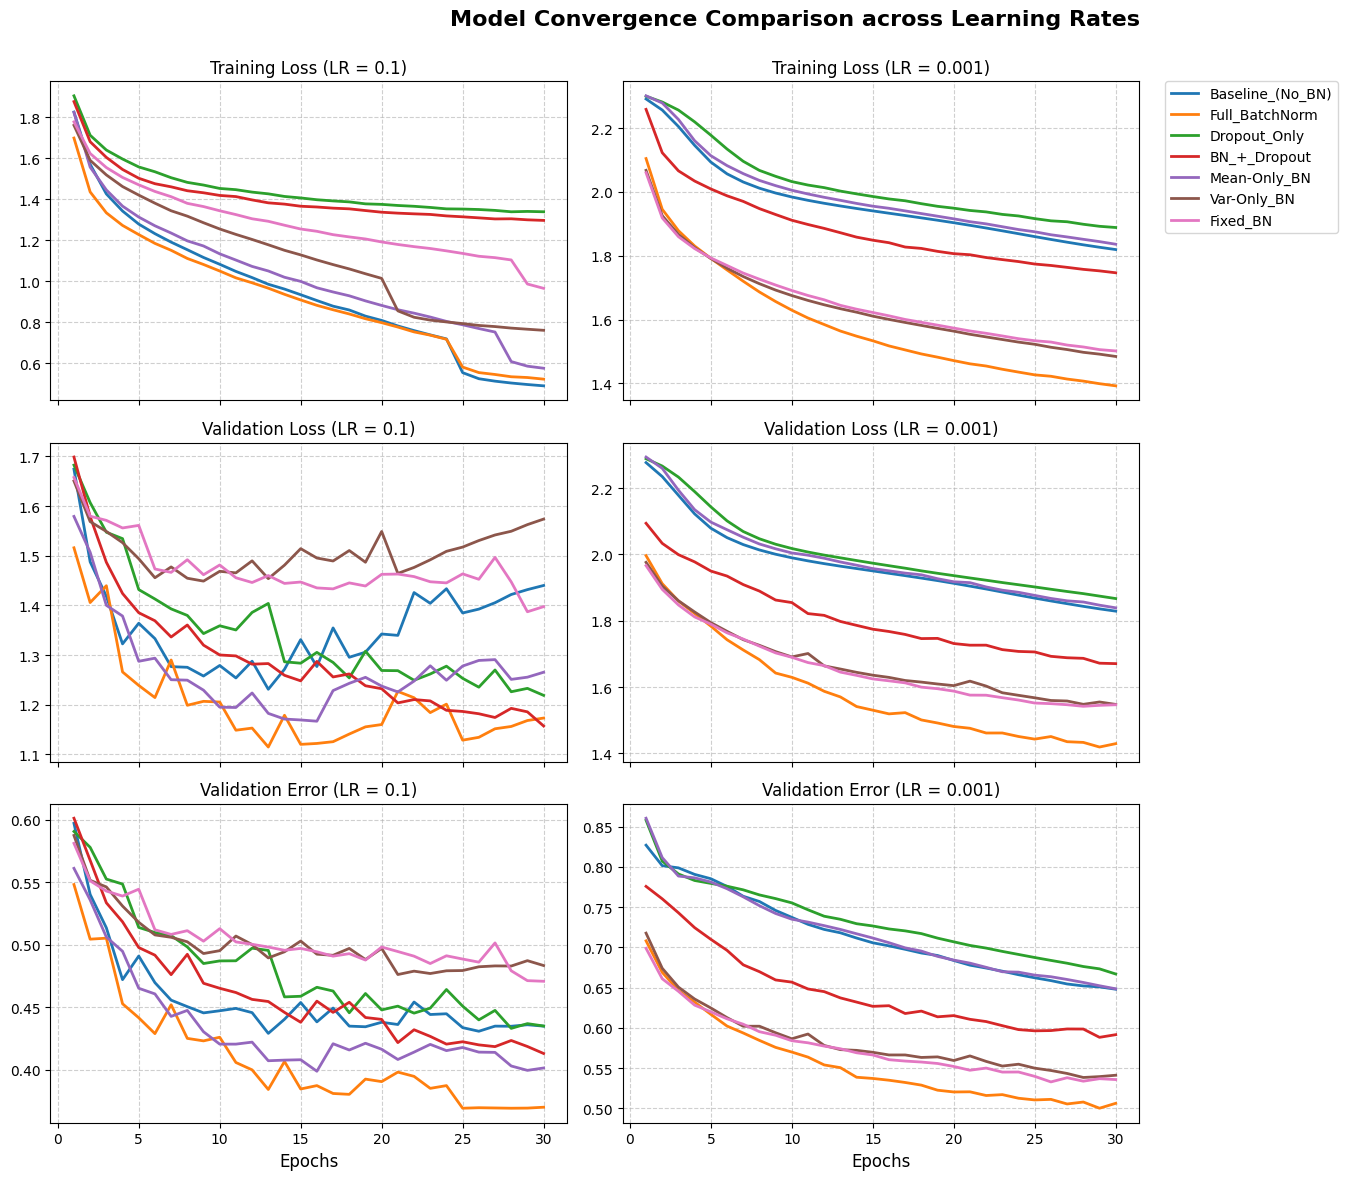

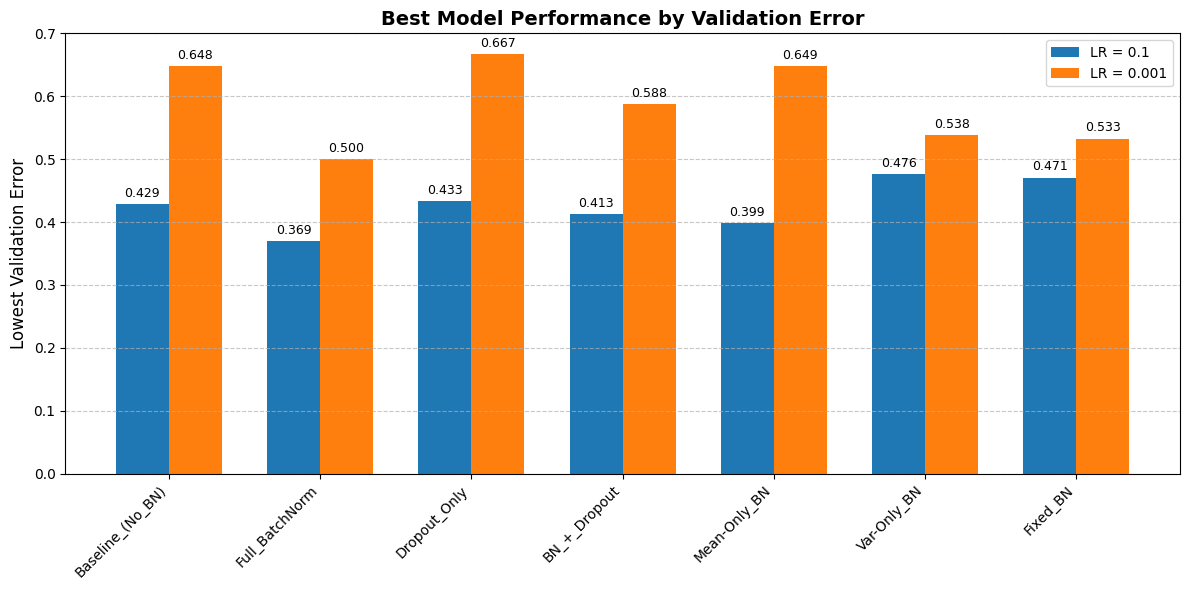

In [13]:
results_lr_01 = results[0::2]
results_lr_001 = results[1::2]

epochs = range(1, len(results_lr_01[0]['history']['train_loss']) + 1)
colors = plt.cm.tab10.colors 

fig, axes = plt.subplots(3, 2, figsize=(16, 12), sharex=True)
fig.suptitle('Model Convergence Comparison across Learning Rates', fontsize=16, fontweight='bold')

metrics = ['train_loss', 'val_loss', 'val_err']
titles = ['Training Loss', 'Validation Loss', 'Validation Error']

for row, metric in enumerate(metrics):
    for idx, model in enumerate(results_lr_01):
        axes[row, 0].plot(epochs, model['history'][metric], label=model['name'], color=colors[idx % len(colors)], linewidth=2)
    axes[row, 0].set_title(f'{titles[row]} (LR = 0.1)')
    axes[row, 0].grid(True, linestyle='--', alpha=0.6)
    
    for idx, model in enumerate(results_lr_001):
        axes[row, 1].plot(epochs, model['history'][metric], label=model['name'], color=colors[idx % len(colors)], linewidth=2)
    axes[row, 1].set_title(f'{titles[row]} (LR = 0.001)')
    axes[row, 1].grid(True, linestyle='--', alpha=0.6)

for ax in axes[2, :]:
    ax.set_xlabel('Epochs', fontsize=12)
    
axes[0, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout(rect=[0, 0, 0.85, 0.98]) 
plt.show()


names = [m['name'] for m in results_lr_01]

best_err_01 = [min(m['history']['val_err']) for m in results_lr_01]
best_err_001 = [min(m['history']['val_err']) for m in results_lr_001]

x = np.arange(len(names))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, best_err_01, width, label='LR = 0.1', color='#1f77b4')
rects2 = ax.bar(x + width/2, best_err_001, width, label='LR = 0.001', color='#ff7f0e')

ax.set_ylabel('Lowest Validation Error', fontsize=12)
ax.set_title('Best Model Performance by Validation Error', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(names, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

for rects in [rects1, rects2]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

From experiment above, we see that model, which has Batch norm, has the best results and the fastest convergence.